In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import nltk
import csv
import networkx as nx
import operator
import matplotlib.pyplot as plt
import pandas as pd
import re

##### loading the data

In [28]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

#training_set = np.array(pd.read_csv("paul_my_train.csv").values)
#testing_set = np.array(pd.read_csv("paul_my_test.csv").values)

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
print(training_set[0][2])

1


##### Graph features computation on authors and articles

##### one might want to add the option of a directed link only if the temporal difference allows us todo so

In [30]:
def graph_articles(citation_set, node_info, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    for node in node_info:
        if node[0] != 'ID':
            print(int(node[0]))
            G.add_node(int(node[0]), year = node[1])
    for i in citation_set:
        if i[2] == 1:
            if G.node[i[0]]['year'] < G.node[i[1]]['year']:
                G.add_edge(i[0], i[1])
            else:
                G.add_edge(i[1], i[0])
    return G

In [31]:
def graph_authors(citation_set, node_info, IDs, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    counter = 0
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        if citation[2] == '1':
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_edge(auth1, auth2)
        else:
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_node(auth1)
                    G.add_node(auth2)
               
        counter += 1
    
        if counter % 5000 == True:
            print(counter, "training examples processsed")
    
    return G
    

In [32]:
def compute_page_rank_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    
    pg_rk_features = []
    for citation in citation_set:
        pg_rk_features.append(pg_rk[citation[0]] + pg_rk[citation[1]])
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [33]:
def compute_page_club_feature_for_articles(citation_set, node_info, G=None):
    if G != G:
        G = graph_articles(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    sorted_pgr = sorted(pg_rk.items(), key=operator.itemgetter(1), reverse = True)
    #sp_keys = sorted_pgr.keys()
    sp_keys = [int(a) if a!='ID' else -1 for (a,b) in sorted_pgr]
    #print(sp_keys)
    sp_keys_seen = dict()
    for s in sp_keys:
        sp_keys_seen[s] = False
    
    #nbedgesin = [0]
    
    pageclub = []
    
    edges = G.to_undirected().edges
    
    in_degs_tuple = list(G.in_degree())
    in_degs = [b for (a,b) in in_degs_tuple]
    k_in = sum(in_degs)/ float(len(in_degs))
    
    n = len(sp_keys)
    
    s=0
    i=1
    kincum=0
    koutcum=0
    
    
    
    undirG = G.to_undirected()
    
    for (k,v) in sorted_pgr:
        edges_i = undirG.edges(k)
        for (a,b) in edges_i:
            #print(k)
            #print(a,b)
            #print(sp_keys[:i])
            if k!= 'ID':
                if int(a) == int(k):
                    if sp_keys_seen[int(b)]:
                        s+=1
                else:
                    if sp_keys_seen[int(a)]:
                        s+=1        
        if k != 'ID':
            sp_keys_seen[int(k)]= True
        else:
            sp_keys_seen[-1] = True
        kincum += G.in_degree(k)
        koutcum += G.out_degree(k)
        #print(s)
        if kincum>0 and koutcum >0:
            pageclub.append((s*k_in*n)/(kincum*koutcum))
            G.node[k]['pageclub'] = (s*k_in*n)/(kincum*koutcum)
        else:
            pageclub.append(1)
            G.node[k]['pageclub'] = 1
            
        i+=1
        
    return pageclub
    
    
    
    
    
    

In [34]:
G = graph_articles(training_set, node_info, directed_or_not = 'y')
features = compute_page_club_feature_for_articles(training_set, node_info, G=G)
print(features)

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1100
1101
1102
1103
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209


11039
11040
11041
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11063
11064
11065
11066
11067
11068
11070
11071
11072
11073
11075
11076
11077
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093
11094
11095
11096
11097
11098
11099
11100
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
1121

106189
106190
106191
106192
106193
106194
106195
106196
106197
106198
106199
106200
106201
106202
106203
106204
106205
106206
106207
106208
106209
106210
106211
106212
106213
106214
106215
106216
106217
106218
106219
106220
106221
106222
106223
106225
106226
106227
106228
106230
106231
106232
106233
106234
106235
106236
106237
106238
106239
106240
106241
106242
106243
106244
106245
106246
106247
106248
106249
106250
106252
106253
106254
106255
106256
106257
106258
106259
106260
106261
106262
106263
106264
106265
106266
106267
106268
106269
106270
106271
106272
106273
106274
106275
106276
106277
106278
106279
106280
106281
106282
106283
106284
106285
106286
106287
107001
107002
107003
107004
107005
107006
107007
107008
107009
107010
107011
107012
107013
107014
107015
107016
107017
107018
107019
107020
107021
107022
107023
107024
107025
107027
107028
107029
107030
107031
107032
107033
107034
107035
107036
107037
107038
107039
107040
107041
107042
107043
107044
107045
107046
107047
107048

112161
112162
112163
112164
112165
112166
112167
112168
112169
112170
112171
112173
112174
112175
112176
112177
112178
112179
112180
112181
112182
112183
112184
112185
112186
112187
112188
112189
112190
112191
112192
112193
112194
112195
112196
112197
112198
112199
112200
112201
112202
112203
112204
112205
112206
112207
112208
112209
112210
112211
112212
112213
112214
112215
112217
112218
112219
112220
112221
112222
112223
112224
112226
112227
112228
112229
112230
112231
112233
112234
112235
112236
112237
112238
112239
112240
112241
112242
112243
112244
112245
112246
112247
112248
112249
112250
112251
112252
112253
112254
112255
112256
112257
112258
112259
112260
112261
112262
112263
112264
201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012
201013
201014
201015
201016
201017
201018
201019
201020
201022
201023
201025
201026
201027
201028
201029
201030
201031
201032
201033
201034
201035
201036
201037
201038
201039
201040
201041
201042
201043
201044
201045

207184
207185
207186
207187
207188
207189
207190
207191
207192
207193
207194
207195
207196
207197
207198
207199
207200
207201
207202
207203
207204
207205
207206
207207
207208
207209
207211
207212
207213
207214
207215
207216
207217
207218
207219
207220
207221
207222
207223
207224
207225
207226
207227
207228
207230
207231
207232
207233
207234
207235
207236
207237
207238
207239
207240
207241
207242
207243
207244
207245
207246
207247
207248
207249
207250
207251
207252
207253
207254
207255
207257
207258
207259
207260
207261
207262
207263
207264
207265
207266
207267
207268
207269
207270
207271
207272
207273
207274
207275
207276
207277
207278
207279
207280
207281
207282
207283
207284
208001
208002
208003
208004
208005
208006
208007
208008
208009
208010
208011
208012
208013
208014
208015
208016
208018
208019
208020
208021
208022
208023
208024
208025
208026
208028
208029
208030
208031
208032
208033
208034
208035
208036
208037
208038
208039
208040
208041
208042
208043
208044
208045
208046
208047

301207
301209
301210
301211
301212
301213
301214
301215
301216
301217
301218
301219
301220
301221
301222
301223
301224
301225
301226
301227
301228
301229
301230
301231
301232
301233
301235
301236
301237
301238
301239
301240
301241
301242
301243
301244
301246
301247
301248
301249
301250
301251
301252
301253
301255
301256
302001
302002
302003
302004
302005
302006
302007
302008
302009
302010
302011
302012
302013
302014
302015
302017
302018
302019
302020
302021
302022
302023
302024
302026
302027
302028
302029
302030
302031
302032
302033
302034
302035
302036
302037
302038
302039
302040
302041
302043
302044
302045
302046
302047
302049
302050
302052
302053
302054
302055
302056
302057
302058
302059
302060
302062
302063
302064
302065
302066
302067
302069
302070
302071
302072
302073
302074
302075
302077
302078
302079
302081
302083
302084
302085
302086
302087
302089
302090
302091
302092
302093
302094
302095
302096
302097
302098
302099
302100
302101
302102
302103
302104
302105
302106
302107
302108

9212089
9212090
9212091
9212092
9212093
9212094
9212095
9212097
9212098
9212099
9212100
9212102
9212103
9212104
9212105
9212106
9212108
9212110
9212112
9212113
9212114
9212115
9212117
9212120
9212121
9212124
9212125
9212126
9212127
9212128
9212129
9212130
9212132
9212134
9212135
9212136
9212137
9212139
9212140
9212141
9212142
9212143
9212145
9212146
9212147
9212148
9212149
9212150
9212151
9212153
9212154
9212155
9212156
9212157
9212158
9301001
9301002
9301003
9301004
9301005
9301006
9301008
9301010
9301011
9301013
9301014
9301015
9301017
9301018
9301019
9301020
9301021
9301022
9301024
9301026
9301028
9301029
9301030
9301031
9301032
9301033
9301034
9301035
9301036
9301037
9301038
9301039
9301040
9301041
9301042
9301043
9301045
9301046
9301047
9301049
9301050
9301051
9301052
9301053
9301054
9301055
9301056
9301058
9301059
9301060
9301061
9301062
9301063
9301065
9301066
9301067
9301068
9301069
9301070
9301074
9301075
9301076
9301077
9301078
9301079
9301080
9301081
9301082
9301083
9301084


9312103
9312104
9312105
9312107
9312108
9312109
9312110
9312111
9312114
9312115
9312118
9312120
9312121
9312122
9312124
9312125
9312127
9312128
9312129
9312132
9312133
9312134
9312135
9312136
9312137
9312138
9312139
9312140
9312141
9312143
9312144
9312145
9312147
9312148
9312150
9312151
9312153
9312154
9312155
9312156
9312158
9312159
9312160
9312161
9312162
9312163
9312164
9312166
9312167
9312168
9312169
9312170
9312171
9312172
9312173
9312174
9312175
9312176
9312177
9312179
9312180
9312181
9312182
9312184
9312185
9312186
9312187
9312188
9312189
9312190
9312192
9312194
9312196
9312197
9312198
9312200
9312201
9312202
9312203
9312204
9312205
9312206
9312207
9312208
9312209
9312210
9312212
9312213
9312214
9312215
9401001
9401002
9401003
9401005
9401006
9401007
9401008
9401009
9401011
9401012
9401013
9401014
9401017
9401019
9401020
9401021
9401024
9401025
9401026
9401027
9401029
9401030
9401031
9401032
9401034
9401036
9401037
9401039
9401040
9401041
9401042
9401043
9401044
9401045
9401046


9412026
9412027
9412029
9412030
9412031
9412032
9412033
9412035
9412036
9412038
9412039
9412040
9412041
9412042
9412043
9412044
9412049
9412050
9412051
9412052
9412053
9412054
9412055
9412056
9412057
9412058
9412059
9412060
9412061
9412062
9412063
9412064
9412065
9412067
9412068
9412069
9412070
9412071
9412072
9412073
9412074
9412075
9412076
9412077
9412078
9412079
9412080
9412081
9412082
9412083
9412084
9412086
9412087
9412088
9412091
9412092
9412093
9412094
9412095
9412096
9412097
9412098
9412099
9412100
9412102
9412103
9412104
9412105
9412106
9412107
9412108
9412109
9412110
9412112
9412113
9412114
9412115
9412116
9412117
9412118
9412119
9412120
9412121
9412123
9412124
9412125
9412126
9412127
9412128
9412129
9412130
9412131
9412132
9412133
9412134
9412135
9412136
9412137
9412138
9412139
9412140
9412141
9412142
9412143
9412144
9412145
9412146
9412147
9412148
9412149
9412150
9412151
9412152
9412153
9412154
9412155
9412156
9412157
9412158
9412159
9412160
9412161
9412162
9412163
9412164


9510209
9510210
9510211
9510212
9510213
9510215
9510216
9510217
9510218
9510219
9510220
9510221
9510222
9510223
9510224
9510225
9510226
9510227
9510228
9510229
9510230
9510231
9510233
9510234
9510235
9510236
9510237
9510238
9510239
9510240
9510241
9510242
9511001
9511002
9511003
9511004
9511006
9511007
9511008
9511009
9511010
9511011
9511013
9511014
9511015
9511016
9511017
9511018
9511019
9511020
9511021
9511022
9511024
9511025
9511026
9511028
9511030
9511031
9511032
9511033
9511034
9511035
9511036
9511037
9511038
9511039
9511040
9511041
9511042
9511043
9511044
9511045
9511046
9511047
9511048
9511049
9511050
9511051
9511052
9511053
9511055
9511056
9511058
9511059
9511060
9511061
9511063
9511064
9511065
9511066
9511067
9511068
9511069
9511070
9511071
9511072
9511073
9511074
9511075
9511076
9511077
9511079
9511080
9511081
9511082
9511083
9511084
9511086
9511087
9511088
9511089
9511090
9511091
9511092
9511093
9511094
9511095
9511096
9511097
9511098
9511100
9511101
9511102
9511103
9511104


9607022
9607023
9607024
9607026
9607027
9607028
9607029
9607030
9607031
9607032
9607035
9607036
9607037
9607038
9607039
9607040
9607041
9607042
9607043
9607044
9607045
9607046
9607047
9607048
9607049
9607050
9607051
9607052
9607053
9607054
9607055
9607056
9607057
9607058
9607059
9607060
9607062
9607064
9607065
9607066
9607067
9607068
9607069
9607070
9607071
9607072
9607073
9607074
9607075
9607076
9607077
9607078
9607079
9607080
9607082
9607083
9607084
9607085
9607086
9607088
9607089
9607090
9607091
9607092
9607093
9607094
9607095
9607096
9607097
9607098
9607099
9607100
9607101
9607102
9607103
9607104
9607105
9607106
9607107
9607108
9607109
9607110
9607111
9607112
9607113
9607114
9607115
9607116
9607117
9607118
9607119
9607120
9607121
9607122
9607123
9607124
9607125
9607126
9607128
9607129
9607130
9607131
9607132
9607133
9607134
9607136
9607137
9607138
9607139
9607140
9607141
9607142
9607143
9607144
9607145
9607146
9607147
9607148
9607149
9607150
9607151
9607152
9607153
9607154
9607155


9703167
9703168
9703169
9703170
9703171
9703172
9703173
9703174
9703176
9703177
9703178
9703179
9703180
9703181
9703182
9703183
9703184
9703185
9703186
9703187
9703188
9703189
9703190
9703191
9703192
9703193
9703194
9703195
9703196
9703197
9703198
9703199
9703200
9703201
9703202
9703203
9703204
9703206
9703207
9703208
9703209
9703210
9703211
9703212
9703213
9703214
9703215
9703216
9703217
9703218
9703219
9703220
9703222
9703224
9703225
9703226
9703227
9703228
9704001
9704002
9704004
9704005
9704006
9704007
9704009
9704010
9704011
9704012
9704013
9704014
9704015
9704016
9704017
9704018
9704019
9704020
9704021
9704022
9704023
9704024
9704025
9704026
9704027
9704028
9704029
9704030
9704031
9704032
9704033
9704034
9704035
9704036
9704037
9704038
9704039
9704040
9704041
9704043
9704044
9704045
9704046
9704047
9704048
9704049
9704050
9704051
9704052
9704054
9704055
9704056
9704057
9704058
9704059
9704060
9704061
9704062
9704063
9704064
9704065
9704066
9704067
9704068
9704069
9704070
9704072


9711021
9711022
9711023
9711024
9711025
9711026
9711027
9711028
9711029
9711030
9711031
9711032
9711033
9711034
9711035
9711036
9711037
9711038
9711039
9711040
9711041
9711042
9711043
9711044
9711045
9711046
9711047
9711048
9711049
9711050
9711051
9711052
9711053
9711054
9711055
9711056
9711057
9711058
9711059
9711060
9711061
9711062
9711063
9711064
9711065
9711066
9711067
9711068
9711069
9711070
9711071
9711072
9711073
9711074
9711075
9711076
9711077
9711078
9711079
9711080
9711081
9711082
9711083
9711084
9711085
9711086
9711087
9711088
9711089
9711090
9711091
9711092
9711093
9711094
9711095
9711096
9711097
9711098
9711099
9711100
9711101
9711102
9711103
9711104
9711105
9711106
9711107
9711108
9711109
9711110
9711111
9711112
9711113
9711114
9711115
9711116
9711117
9711118
9711119
9711120
9711122
9711123
9711124
9711125
9711126
9711127
9711128
9711129
9711130
9711131
9711132
9711133
9711134
9711135
9711136
9711137
9711138
9711139
9711140
9711141
9711142
9711143
9711144
9711145
9711146


9806039
9806040
9806041
9806042
9806043
9806044
9806045
9806046
9806047
9806048
9806049
9806050
9806051
9806052
9806053
9806054
9806055
9806056
9806057
9806059
9806060
9806062
9806063
9806064
9806065
9806066
9806067
9806068
9806069
9806070
9806071
9806072
9806073
9806074
9806075
9806076
9806077
9806078
9806079
9806080
9806081
9806082
9806083
9806084
9806085
9806086
9806087
9806088
9806089
9806090
9806091
9806092
9806093
9806094
9806095
9806096
9806097
9806098
9806099
9806100
9806101
9806102
9806103
9806104
9806105
9806106
9806107
9806108
9806109
9806110
9806111
9806112
9806113
9806114
9806115
9806116
9806117
9806118
9806119
9806120
9806121
9806122
9806123
9806124
9806125
9806126
9806127
9806128
9806129
9806130
9806131
9806132
9806133
9806134
9806135
9806136
9806137
9806138
9806139
9806140
9806141
9806142
9806143
9806144
9806145
9806146
9806147
9806148
9806149
9806150
9806151
9806152
9806153
9806154
9806155
9806156
9806157
9806158
9806159
9806160
9806161
9806162
9806163
9806164
9806165


9902116
9902117
9902118
9902119
9902120
9902121
9902122
9902123
9902124
9902125
9902126
9902127
9902128
9902129
9902130
9902131
9902132
9902133
9902134
9902135
9902136
9902137
9902138
9902139
9902140
9902141
9902142
9902143
9902144
9902145
9902146
9902147
9902148
9902149
9902150
9902151
9902153
9902154
9902155
9902156
9902157
9902158
9902159
9902160
9902161
9902162
9902163
9902164
9902165
9902166
9902167
9902168
9902169
9902170
9902171
9902173
9902174
9902175
9902176
9902177
9902178
9902179
9902180
9902181
9902183
9902184
9902185
9902186
9902187
9902188
9902189
9902190
9902191
9902192
9902194
9902195
9902196
9902197
9902198
9902199
9902200
9902201
9902202
9902203
9902204
9902205
9902206
9902207
9902208
9902209
9902210
9902211
9903001
9903002
9903003
9903004
9903005
9903006
9903007
9903008
9903009
9903010
9903011
9903012
9903013
9903014
9903015
9903016
9903017
9903018
9903019
9903020
9903021
9903022
9903023
9903024
9903025
9903026
9903027
9903028
9903029
9903030
9903031
9903032
9903033


9910004
9910005
9910006
9910007
9910008
9910009
9910010
9910011
9910012
9910013
9910014
9910015
9910016
9910017
9910019
9910020
9910021
9910022
9910023
9910024
9910025
9910027
9910028
9910029
9910030
9910031
9910032
9910033
9910035
9910036
9910037
9910038
9910039
9910040
9910041
9910042
9910043
9910044
9910045
9910046
9910047
9910048
9910049
9910050
9910051
9910052
9910053
9910054
9910055
9910056
9910057
9910058
9910059
9910060
9910061
9910062
9910064
9910065
9910066
9910067
9910068
9910069
9910070
9910071
9910073
9910074
9910075
9910076
9910077
9910078
9910079
9910080
9910081
9910082
9910083
9910084
9910085
9910086
9910087
9910088
9910089
9910090
9910091
9910092
9910093
9910094
9910095
9910096
9910097
9910098
9910099
9910100
9910101
9910102
9910103
9910104
9910105
9910106
9910107
9910108
9910109
9910110
9910111
9910112
9910113
9910114
9910115
9910116
9910117
9910118
9910119
9910121
9910122
9910123
9910124
9910125
9910126
9910127
9910128
9910129
9910130
9910131
9910132
9910133
9910134


In [35]:
pagerank = nx.pagerank(G)
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
fin_pgr = [b for (a,b) in sorted_pgr]
key_pgr = [a for (a,b) in sorted_pgr]
key_dict = dict()
for i in range(len(key_pgr)):
    key_dict[key_pgr[i]]=i

features[0] = fin_pgr[0]*features[1]/fin_pgr[1]
print(key_dict)

{9306112: 0, 9306114: 1, 9306115: 2, 9306116: 3, 9306117: 4, 9306118: 5, 9306119: 6, 9306120: 7, 9306122: 8, 9306123: 9, 9306125: 10, 9306129: 11, 9306130: 12, 9306131: 13, 9306132: 14, 9306134: 15, 9306135: 16, 9306136: 17, 9306137: 18, 9306139: 19, 9306140: 20, 9306141: 21, 9306142: 22, 9306144: 23, 9306145: 24, 9306146: 25, 9306147: 26, 9306148: 27, 9306149: 28, 9306150: 29, 9306151: 30, 9306152: 31, 9306153: 32, 9306154: 33, 9306155: 34, 9306156: 35, 9306157: 36, 9306161: 37, 9306162: 38, 9306163: 39, 9306164: 40, 9307001: 42, 9307002: 43, 9307003: 44, 9307005: 45, 9307006: 46, 9307007: 47, 9307008: 48, 9307009: 49, 9307010: 50, 9307011: 51, 9307012: 52, 9307013: 53, 9307015: 54, 9307016: 55, 9307017: 56, 9307018: 57, 9307022: 58, 9307023: 59, 9307024: 60, 9307025: 61, 9307026: 62, 9307027: 63, 9307029: 64, 9307030: 65, 9307031: 66, 9307032: 67, 9307033: 68, 9307034: 69, 9307035: 70, 9307036: 71, 9307037: 72, 9307038: 73, 9307039: 74, 9307040: 75, 9307042: 76, 9307043: 77, 9307045:

In [36]:
fin_pgr[9431]

3.601008282317691e-05

In [39]:
features_edges = []
pagerank_edges = []
for citation in training_set:
        ic0 = key_dict[int(citation[0])]
        ic1 = key_dict[int(citation[1])]
        features_edges.append(G.node[int(citation[0])]['pageclub'] + G.node[int(citation[1])]['pageclub'])
        pagerank_edges.append(fin_pgr[ic0] + fin_pgr[ic1])

In [40]:
print(pagerank_edges[:100])

[7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.202016564635382e-05, 7.20201656

In [41]:
len(features_edges)

615512

In [42]:
data_test=[]
for i in range(len(pagerank_edges)):
    data_test.append([pagerank_edges[i],features_edges[i]])
print(data_test[:10])

[[7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2]]


In [43]:
with open("./louis_training_graph_page.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow([a])

In [44]:
key_dict[9510123]

14085

In [45]:
features_edgestest = []
pagerank_edgestest = []
for citation in testing_set:
    if citation[0] != 'ID1':
        #print(citation[0])
        #print(key_dict[int(citation[0])])
        ic0 = key_dict[int(citation[0])]
        #print(ic0)
        #print(citation[1])
        ic1 = key_dict[int(citation[1])]
        
        features_edgestest.append(G.node[int(citation[0])]['pageclub'] + G.node[int(citation[1])]['pageclub'])
        pagerank_edgestest.append(fin_pgr[ic0] + fin_pgr[ic1])

In [46]:
data_test=[]
for i in range(len(pagerank_edgestest)):
    data_test.append([pagerank_edgestest[i],features_edgestest[i]])
print(data_test[:10])

[[7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2], [7.202016564635382e-05, 2]]


In [47]:


with open("./louis_testing_graph_page.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow([a])

### La feature a enregistré est feature_edges au dessus, le reste est des tests et reste du fichier de yannis

In [146]:
print(sorted_pgr[:10])

[(303256, 0.00170318373688099), (204253, 0.0009298355926681889), (303207, 0.0009005276311660342), (304018, 0.0008387034133328405), (304262, 0.0008361877809952189), (303095, 0.0008177063455503618), (204089, 0.0008050376334219899), (303011, 0.000788382583099261), (211178, 0.0007816514287760656), (207116, 0.0007743556217864901)]


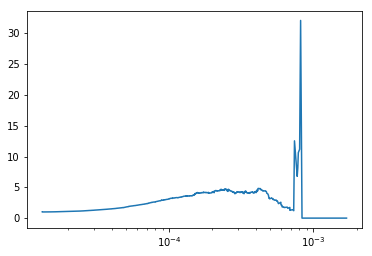

In [128]:
plt.xscale('log')
plt.plot(fin_pgr,features)
plt.show()

In [138]:
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
sp_keys = [float(b) for (a,b) in sorted_pgr]
print(len(sp_keys) != len(set(sp_keys)))

True


In [139]:
print(sp_keys)

[0.00170318373688099, 0.0009298355926681889, 0.0009005276311660342, 0.0008387034133328405, 0.0008361877809952189, 0.0008177063455503618, 0.0008050376334219899, 0.000788382583099261, 0.0007816514287760656, 0.0007743556217864901, 0.000741361038858943, 0.0007322468022830154, 0.0007237932924229044, 0.0007065588590957429, 0.0006901538325716295, 0.0006889834527718087, 0.0006883762470008862, 0.0006749997141879593, 0.0006654647055925303, 0.0006601841682386726, 0.0006470134393397561, 0.0006458085188586262, 0.0006394617423679684, 0.0006372379828555201, 0.0006274635604131289, 0.0006224108423009532, 0.0006098330474289262, 0.0006079070781568649, 0.0006073455483150611, 0.0006031915464318257, 0.0005990387078954609, 0.0005967193607083608, 0.0005967096062280244, 0.0005964674576021343, 0.0005960748071113137, 0.0005898081882260201, 0.0005739681284665157, 0.0005724132005659443, 0.0005648353639742826, 0.0005594226464594777, 0.0005575843566696391, 0.0005558485226841963, 0.0005516236390795198, 0.000542244401

##### beware, they are quite long to compute each

In [3]:
def compute_page_rank_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    pg_rk_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += pg_rk[auth]
        
        pg_rk_features.append(feature)
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [26]:
def compute_rich_club_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    
    rc_cl_features = []
    for citation in citation_set:
        rc_cl_features.append(rc_cl[citation[0]] + rc_cl[citation[1]])
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [25]:
def compute_rich_club_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    rc_cl_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += rc_cl[auth]
        
        rc_cl_features.append(feature)
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [16]:
def compute_shorthest_path_feature_for_articles(citation_set,G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    sht_pth_features = []
    for citation in citation_set:
        if citation[2] == '1':
            G.remove_edge(citation[0], citation[1])
        sht_pth_features.append(
                nx.shortest_path_length(G,citation[0], citation[1]) if nx.has_path(G, citation[0], citation[1]) else 30)
        if citation[2] == '1':
            G.add_edge(citation[0], citation[1])
    
    if bool:
        return np.array(sht_pth_features), G
    else:
        return np.array(sht_pth_features)